## Setup

### Import Statements

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import ttest_ind
from statannot import add_stat_annotation

import warnings
warnings.filterwarnings('ignore')

### Load in gender and age info of each subject

In [2]:
# read in average ICD values
gender_age_data = pd.read_csv('subject_demographics_595.txt',sep = '\t',names = ['subj_ID','age_months','gender'])
# display first 20 data values to check that read-in was successful
gender_age_data.head(5)

,subj_ID,age_months,gender
0,HCA6030645,544,F
1,HCA6031344,967,F
2,HCA6037457,880,F
3,HCA6051047,725,F
4,HCA6053758,437,F


### Create function to plot linear and quadratic regressions, as well as jointplots (to show datapoint distribution)

In [3]:
def conn_vs_age_plot(df, y, avg_or_peak, icd_or_seed):
    linear_lmplot = sns.lmplot(data = df, x = 'age', y = y, hue = 'gender', palette = ['r', 'b'], scatter_kws = {"alpha": 0.1})
#     plt.savefig("figures/" + icd_or_seed + "/" + avg_or_peak + "/" + icd_or_seed + "_" + avg_or_peak + "_linear_" + y + ".png")
    plt.clf()
    quadratic_lmplot = sns.lmplot(data = df, x = 'age', y = y, hue = 'gender', palette = ['r', 'b'], order = 2, scatter_kws = {"alpha": 0.1})
#     plt.savefig("figures/" + icd_or_seed + "/" + avg_or_peak + "/" + icd_or_seed + "_" + avg_or_peak + "_quadratic_" + y + ".png")
    plt.clf()
    dist_plot = sns.jointplot(data = df, x = 'age', y = y, hue = 'gender', palette = ['r', 'b'])
#     plt.savefig("figures/" + icd_or_seed + "/" + "jointplots/" + icd_or_seed + "_" + avg_or_peak + "_jointplot_" + y + ".png")
    plt.clf()

### Create function to get correlation coefficients and p values for each fit (only linear for now!)

In [5]:
def get_r_p(df, y, avg_or_peak, icd_or_seed):
    g = sns.lmplot(data = df, x='age', y=y, col='gender', height=3, aspect=1)
    
    def annotate(data, **kws):
        r, p = sp.stats.pearsonr(data['age'], data[y])
        ax = plt.gca()
        ax.text(.05, .9, 'r={:.2f}, p={:.2g}'.format(r, p),
                transform=ax.transAxes)
        print(r)
        print(p)

    g.map_dataframe(annotate)
    plt.show()

### Create function to visualize connectivity data by decade using boxplots

In [6]:
def conn_vs_age_boxplot(df, y, icd_or_seed):
    
# boxplots version 1
#     fig, axes = plt.subplots(1, 2, sharey = True, figsize=(15, 5))
#     fig.suptitle(y + " avg " + icd_or_seed + " values")
#     df["age_group"] = pd.cut(df["age"], bins = range(30, 101, 10))
#     ax0 = sns.boxplot(data = df[df["gender"] == 'F'], x = "age_group", y = y, ax = axes[0])
#     ax0.set_title("Women")
#     ax1 = sns.boxplot(data = df[df["gender"] == 'M'], x = "age_group", y = y, ax = axes[1])
#     ax1.set_title("Men")
#     plt.savefig("figures/boxplots/boxplot_" + icd_or_seed + "_" + y + ".png")
#     plt.clf()
    
# boxplots version 2 (shows the boxplots of women and men side by side, also shows the mean on top of boxplots)
    df["age_group"] = pd.cut(df["age"], bins = range(30, 101, 10))
    
    gender_list = sorted(df['gender'].unique())
#     print(gender_list)
    age_group_list = sorted(df['age_group'].unique())
#     print(age_group_list)
    
    df_F = df[df['gender'] == 'F']
    df_M = df[df['gender'] == 'M']
    m_F = df_F.groupby('age_group')[y].mean()
    m_M = df_M.groupby('age_group')[y].mean()
    
    fig = sns.boxplot(data = df, x = "age_group", y = y, hue = "gender", showmeans = True, palette = ['r','b'])
    fig.set_title(y + " avg " + icd_or_seed + " values")
    # documentation for add_stat_annotation: https://github.com/webermarcolivier/statannot/blob/master/example/example.ipynb
    add_stat_annotation(fig, data=df, x = "age_group", y = y, hue = "gender", 
                        box_pairs=[((age_group_list[0], gender_list[0]), (age_group_list[0], gender_list[1])),
                                   ((age_group_list[1], gender_list[0]), (age_group_list[1], gender_list[1])),
                                   ((age_group_list[2], gender_list[0]), (age_group_list[2], gender_list[1])),
                                   ((age_group_list[3], gender_list[0]), (age_group_list[3], gender_list[1])),
                                   ((age_group_list[4], gender_list[0]), (age_group_list[4], gender_list[1])),
                                   ((age_group_list[5], gender_list[0]), (age_group_list[5], gender_list[1])),
                                   ((age_group_list[6], gender_list[0]), (age_group_list[6], gender_list[1])),],
                        test='t-test_ind', text_format='star', loc='inside', verbose=2) # to remove the Bonferroni correction, add this parameter: comparisons_correction=None
    
    fig.plot([-0.2,.8,1.8,2.8,3.8,4.8,5.8],m_F.values,'r--', linewidth = 2)
    fig.plot([.2,1.2,2.2,3.2,4.2,5.2,6.2],m_M.values,'b--', linewidth = 2)
    
    lg = plt.legend(loc='upper left', bbox_to_anchor=(0.985, 1))
#     plt.savefig("figures/boxplots/star_boxplot_" + icd_or_seed + "_" + y + ".png", bbox_extra_artists=(lg,), bbox_inches='tight')
    plt.clf()

### Create function to perform t-test comparing male and female connectivity data by decade

In [8]:
def ttest_age(df, y, icd_or_seed):

    # create dataframes in a dictionary for each decade
    d = {}
    keys = []
    for i in range(30,91,10):
        keys.append(str(i) + "_" + str(i + 10))
    age = 30
    for k in keys:
        d[k] = df[(df['age'] > age) & (df['age'] <= (age + 10))]
        age += 10

    # create dataframe to store all t and p values for each age group from t-test
    ttest_values = pd.DataFrame(columns = ['age_group', 'ROI', 't value', 'p value'])

    # populate t and p value dataframe
    age = 30
    for key, dataframe in d.items():
        age_str = str(age) + "_" + str(age + 10)
        t, p = ttest_ind(dataframe[dataframe['gender'] == 'F'][y], dataframe[dataframe['gender'] == 'M'][y])
        ttest_values = ttest_values.append({'age_group':age_str, 'ROI':y, 't value': t, 'p value': p}, ignore_index = True)
        age += 10
    # NOTE: warning will appear after running this for loop and 90_100 age group will have NaN for t and p values 
    # because there is only 1 man vs 4 women in that age group
    
    return ttest_values
#     # write age groups, t values, and p values to a .txt file
#     ttest_values.to_csv('t_test_' + icd_or_seed + '.txt', mode = 'a')
#     print(ttest_values)

# Male-Female ICD analysis

## AVERAGE ICD

### Load in Male-Female average ICD values

In [9]:
# read in average ICD values
icd_avg_data = pd.read_csv('ROIs_DMNicdnorm_restavg_Male-Female_p001_cl12_SUYEON_final_FULL.txt',sep = '\t',skip_blank_lines = True,skiprows = [1])
# # display first 5 data values to check that read-in was successful
# icd_avg_data.head(5)
# list(icd_avg_data.columns) # lists all of the column names

### Make new dataframe with only necessary data from both read-in datasets

In [10]:
# create empty dataframe with necessary column names
master_data_avg_icd = pd.DataFrame(columns = ['subj_id','gender','age','L_PCC','L_AngGyr','R_AngGyr','L_Parahip','R_Parahip','R_STS'])

# add rows to dataframe
master_data_avg_icd['subj_id'] = gender_age_data['subj_ID']
master_data_avg_icd['gender'] = gender_age_data['gender']
master_data_avg_icd['age'] = gender_age_data['age_months']/12
master_data_avg_icd['L_PCC'] = icd_avg_data[' ROI26_L_BA23_31_PCC  ']
master_data_avg_icd['L_AngGyr'] = icd_avg_data[' ROI30_L_BA39_AngGyr  ']
master_data_avg_icd['R_AngGyr'] = icd_avg_data[' ROI25_R_BA39_AngGyr  ']
master_data_avg_icd['L_Parahip'] = icd_avg_data[' ROI2_L_Parahip  ']
master_data_avg_icd['R_Parahip'] = icd_avg_data[' ROI3_R_Parahip  ']
master_data_avg_icd['R_STS'] = icd_avg_data[' ROI21_R_BA22_STS  ']

# display first 5 data values to check that dataframe was successfully generated
master_data_avg_icd.head(5)
# print(master_data_avg_icd) # displays the whole master_data dataframe

,subj_id,gender,age,L_PCC,L_AngGyr,R_AngGyr,L_Parahip,R_Parahip,R_STS
0,HCA6030645,F,45.333333,-0.1273,0.1380,0.1901,-0.0068,-0.0101,-0.0387
1,HCA6031344,F,80.583333,-0.0199,0.2461,0.0561,-0.0909,-0.1212,-0.1459
2,HCA6037457,F,73.333333,0.1150,-0.7801,-0.1546,-0.0382,-0.0325,-0.1796
3,HCA6051047,F,60.416667,0.0007,0.4050,0.4419,0.2759,0.1730,-0.0259
4,HCA6053758,F,36.416667,-0.3016,-0.0312,0.0279,-0.0808,-0.1185,-0.0628


### Create empty dataframe to store all t-test values

In [11]:
ttest_icd = pd.DataFrame(columns = ['age_group', 'ROI', 't value', 'p value'])

### Plot the average ICD values vs. age with gender labels and linear fit lines
##### Note: since these are average values, the fits are most likely all linear

In [12]:
# conn_vs_age_plot(master_data_avg_icd, "L_PCC", "avg", "icd")
# conn_vs_age_plot(master_data_avg_icd, "L_AngGyr", "avg", "icd")
# conn_vs_age_plot(master_data_avg_icd, "R_AngGyr", "avg", "icd")
# conn_vs_age_plot(master_data_avg_icd, "L_Parahip", "avg", "icd")
# conn_vs_age_plot(master_data_avg_icd, "R_Parahip", "avg", "icd")
# conn_vs_age_plot(master_data_avg_icd, "R_STS", "avg", "icd")

### Get linear regression correlation info (r and p values)

-0.1064656450133992
0.04783441489779247
-0.15621990144080167
0.013591763607538412


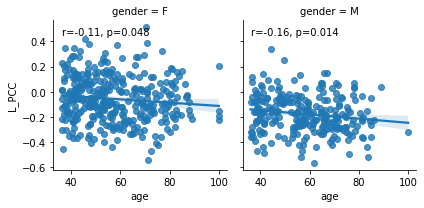

In [13]:
# get r and p values for L_PCC ROI
get_r_p(master_data_avg_icd, "L_PCC", "avg", "icd")

-0.196093998094015
0.00024249984733047748
-0.024713924101245607
0.697959669397627


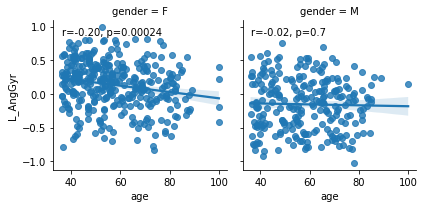

In [14]:
get_r_p(master_data_avg_icd, "L_AngGyr", "avg", "icd")

-0.1812803599169805
0.0007042492470372055
-0.06763992695241627
0.28769688991562586


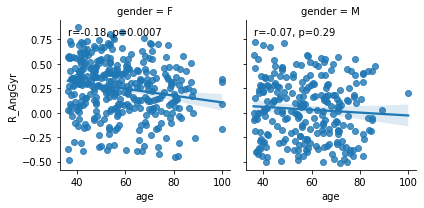

In [15]:
get_r_p(master_data_avg_icd, "R_AngGyr", "avg", "icd")

0.2239346154247454
2.6240282038666496e-05
0.056214786810806036
0.3770797862472608


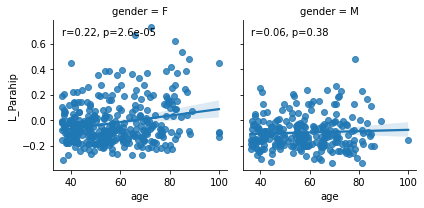

In [16]:
get_r_p(master_data_avg_icd, "L_Parahip", "avg", "icd")

0.24345607213609025
4.621605286146441e-06
0.0837716510066085
0.187650969494494


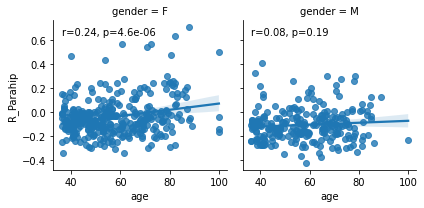

In [17]:
get_r_p(master_data_avg_icd, "R_Parahip", "avg", "icd")

-0.36996715651929263
1.1540170275691853e-12
-0.24967599634842358
6.797537942879754e-05


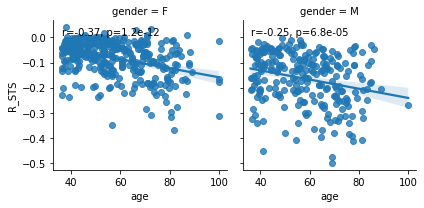

In [18]:
get_r_p(master_data_avg_icd, "R_STS", "avg", "icd")

### Generate boxplots with p-value annotations/mean trend lines

In [19]:
# L_PCC female vs male boxplot
conn_vs_age_boxplot(master_data_avg_icd, "L_PCC", "icd")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

(40, 50]_F v.s. (40, 50]_M: t-test independent samples with Bonferroni correction, P_val=2.165e-02 stat=3.008e+00
(30, 40]_F v.s. (30, 40]_M: t-test independent samples with Bonferroni correction, P_val=1.889e-02 stat=3.124e+00
(50, 60]_F v.s. (50, 60]_M: t-test independent samples with Bonferroni correction, P_val=2.945e-05 stat=4.801e+00
(60, 70]_F v.s. (60, 70]_M: t-test independent samples with Bonferroni correction, P_val=7.761e-03 stat=3.354e+00
(70, 80]_F v.s. (70, 80]_M: t-test independent samples with Bonferroni correction, P_val=1.350e-01 stat=2.384e+00
(80, 90]_F v.s. (80, 90]_M: t-test independent samples with Bonferroni correction, P_val=6.075e-04 stat=4.344e+00
(90, 100]_F v.s. (90, 100]_M: t-test independent samples with Bonferroni correction, P_val=nan stat=nan


<Figure size 432x288 with 0 Axes>

In [20]:
# L_AngGyr female vs male boxplot
conn_vs_age_boxplot(master_data_avg_icd, "L_AngGyr", "icd")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

(40, 50]_F v.s. (40, 50]_M: t-test independent samples with Bonferroni correction, P_val=6.851e-05 stat=4.580e+00
(30, 40]_F v.s. (30, 40]_M: t-test independent samples with Bonferroni correction, P_val=1.734e-04 stat=4.553e+00
(50, 60]_F v.s. (50, 60]_M: t-test independent samples with Bonferroni correction, P_val=3.247e-06 stat=5.304e+00
(60, 70]_F v.s. (60, 70]_M: t-test independent samples with Bonferroni correction, P_val=6.463e-02 stat=2.652e+00
(70, 80]_F v.s. (70, 80]_M: t-test independent samples with Bonferroni correction, P_val=7.624e-03 stat=3.378e+00
(80, 90]_F v.s. (80, 90]_M: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.343e+00
(90, 100]_F v.s. (90, 100]_M: t-test independent samples with Bonferroni correction, P_val=nan stat=nan


<Figure size 432x288 with 0 Axes>

In [21]:
# R_AngGyr female vs male boxplot
conn_vs_age_boxplot(master_data_avg_icd, "R_AngGyr", "icd")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

(40, 50]_F v.s. (40, 50]_M: t-test independent samples with Bonferroni correction, P_val=5.534e-05 stat=4.631e+00
(30, 40]_F v.s. (30, 40]_M: t-test independent samples with Bonferroni correction, P_val=7.574e-02 stat=2.626e+00
(50, 60]_F v.s. (50, 60]_M: t-test independent samples with Bonferroni correction, P_val=2.221e-06 stat=5.388e+00
(60, 70]_F v.s. (60, 70]_M: t-test independent samples with Bonferroni correction, P_val=3.074e-02 stat=2.912e+00
(70, 80]_F v.s. (70, 80]_M: t-test independent samples with Bonferroni correction, P_val=8.430e-04 stat=4.025e+00
(80, 90]_F v.s. (80, 90]_M: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=8.837e-01
(90, 100]_F v.s. (90, 100]_M: t-test independent samples with Bonferroni correction, P_val=nan stat=nan


<Figure size 432x288 with 0 Axes>

In [22]:
# L_Parahip female vs male boxplot
conn_vs_age_boxplot(master_data_avg_icd, "L_Parahip", "icd")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

(40, 50]_F v.s. (40, 50]_M: t-test independent samples with Bonferroni correction, P_val=6.364e-02 stat=2.643e+00
(30, 40]_F v.s. (30, 40]_M: t-test independent samples with Bonferroni correction, P_val=1.005e-01 stat=2.518e+00
(50, 60]_F v.s. (50, 60]_M: t-test independent samples with Bonferroni correction, P_val=5.328e-01 stat=1.788e+00
(60, 70]_F v.s. (60, 70]_M: t-test independent samples with Bonferroni correction, P_val=4.424e-02 stat=2.787e+00
(70, 80]_F v.s. (70, 80]_M: t-test independent samples with Bonferroni correction, P_val=5.267e-01 stat=1.800e+00
(80, 90]_F v.s. (80, 90]_M: t-test independent samples with Bonferroni correction, P_val=8.787e-03 stat=3.459e+00
(90, 100]_F v.s. (90, 100]_M: t-test independent samples with Bonferroni correction, P_val=nan stat=nan


<Figure size 432x288 with 0 Axes>

In [23]:
# R_Parahip female vs male boxplot
conn_vs_age_boxplot(master_data_avg_icd, "R_Parahip", "icd")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

(40, 50]_F v.s. (40, 50]_M: t-test independent samples with Bonferroni correction, P_val=5.325e-02 stat=2.706e+00
(30, 40]_F v.s. (30, 40]_M: t-test independent samples with Bonferroni correction, P_val=3.559e-01 stat=1.991e+00
(50, 60]_F v.s. (50, 60]_M: t-test independent samples with Bonferroni correction, P_val=1.151e-01 stat=2.430e+00
(60, 70]_F v.s. (60, 70]_M: t-test independent samples with Bonferroni correction, P_val=9.117e-01 stat=1.525e+00
(70, 80]_F v.s. (70, 80]_M: t-test independent samples with Bonferroni correction, P_val=2.138e-01 stat=2.198e+00
(80, 90]_F v.s. (80, 90]_M: t-test independent samples with Bonferroni correction, P_val=3.760e-02 stat=2.936e+00
(90, 100]_F v.s. (90, 100]_M: t-test independent samples with Bonferroni correction, P_val=nan stat=nan


<Figure size 432x288 with 0 Axes>

In [24]:
# R_STS female vs male boxplot
conn_vs_age_boxplot(master_data_avg_icd, "R_STS", "icd")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

(40, 50]_F v.s. (40, 50]_M: t-test independent samples with Bonferroni correction, P_val=5.427e-09 stat=6.577e+00
(30, 40]_F v.s. (30, 40]_M: t-test independent samples with Bonferroni correction, P_val=2.728e-04 stat=4.425e+00
(50, 60]_F v.s. (50, 60]_M: t-test independent samples with Bonferroni correction, P_val=9.812e-06 stat=5.056e+00
(60, 70]_F v.s. (60, 70]_M: t-test independent samples with Bonferroni correction, P_val=5.879e-07 stat=5.762e+00
(70, 80]_F v.s. (70, 80]_M: t-test independent samples with Bonferroni correction, P_val=2.840e-04 stat=4.322e+00
(80, 90]_F v.s. (80, 90]_M: t-test independent samples with Bonferroni correction, P_val=9.281e-01 stat=1.534e+00
(90, 100]_F v.s. (90, 100]_M: t-test independent samples with Bonferroni correction, P_val=nan stat=nan


<Figure size 432x288 with 0 Axes>

### Perform t-test between women and men by decade and collect t scores and p values (performed without Bonferroni correction!)

In [25]:
# perform t-test to compared L_PCC values between women and men by decade
ttest_icd = ttest_icd.append(ttest_age(master_data_avg_icd, 'L_PCC', 'icd'))
ttest_icd = ttest_icd.append(ttest_age(master_data_avg_icd, 'L_AngGyr', 'icd'))
ttest_icd = ttest_icd.append(ttest_age(master_data_avg_icd, 'R_AngGyr', 'icd'))
ttest_icd = ttest_icd.append(ttest_age(master_data_avg_icd, 'L_Parahip', 'icd'))
ttest_icd = ttest_icd.append(ttest_age(master_data_avg_icd, 'R_Parahip', 'icd'))
ttest_icd = ttest_icd.append(ttest_age(master_data_avg_icd, 'R_STS', 'icd'))

### Write all t-test values (stored in ttest_icd dataframe) into a .txt file

In [26]:
# write age groups, t values, and p values to a .txt file
ttest_icd.to_csv('ttest_icd.txt')
# print(ttest_icd)

### Generate plot to visualize all t values

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


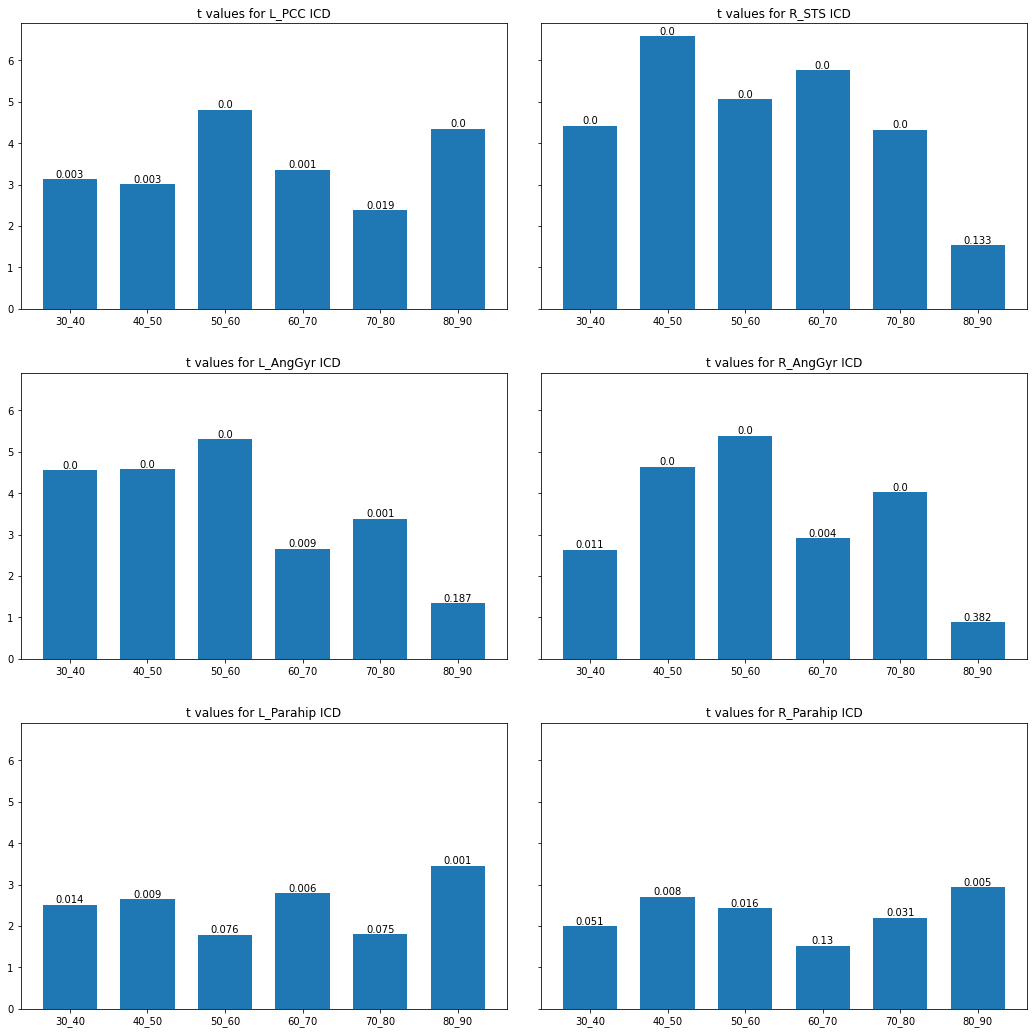

In [27]:
fig, axs = plt.subplots(3, 2, figsize = [15,15], sharey=True)
axs[0, 0].bar(ttest_icd[ttest_icd['ROI'] == 'L_PCC']['age_group'], ttest_icd[ttest_icd['ROI'] == 'L_PCC']['t value'], width = 0.7)
axs[0, 0].set_title("t values for L_PCC ICD")
axs[0, 1].bar(ttest_icd[ttest_icd['ROI'] == 'R_STS']['age_group'], ttest_icd[ttest_icd['ROI'] == 'R_STS']['t value'], width = 0.7)
axs[0, 1].set_title("t values for R_STS ICD")
axs[1, 0].bar(ttest_icd[ttest_icd['ROI'] == 'L_AngGyr']['age_group'], ttest_icd[ttest_icd['ROI'] == 'L_AngGyr']['t value'], width = 0.7)
axs[1, 0].set_title("t values for L_AngGyr ICD")
axs[1, 1].bar(ttest_icd[ttest_icd['ROI'] == 'R_AngGyr']['age_group'], ttest_icd[ttest_icd['ROI'] == 'R_AngGyr']['t value'], width = 0.7)
axs[1, 1].set_title("t values for R_AngGyr ICD")
axs[2, 0].bar(ttest_icd[ttest_icd['ROI'] == 'L_Parahip']['age_group'], ttest_icd[ttest_icd['ROI'] == 'L_Parahip']['t value'], width = 0.7)
axs[2, 0].set_title("t values for L_Parahip ICD")
axs[2, 1].bar(ttest_icd[ttest_icd['ROI'] == 'R_Parahip']['age_group'], ttest_icd[ttest_icd['ROI'] == 'R_Parahip']['t value'], width = 0.7)
axs[2, 1].set_title("t values for R_Parahip ICD")

rects = axs[0, 0].patches
labels = round(ttest_icd[ttest_icd['ROI'] == 'L_PCC']['p value'], 3)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[0, 0].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
    
rects = axs[0, 1].patches
labels = round(ttest_icd[ttest_icd['ROI'] == 'R_STS']['p value'], 3)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[0, 1].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
    
rects = axs[1, 0].patches
labels = round(ttest_icd[ttest_icd['ROI'] == 'L_AngGyr']['p value'], 3)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[1, 0].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
    
rects = axs[1, 1].patches
labels = round(ttest_icd[ttest_icd['ROI'] == 'R_AngGyr']['p value'], 3)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[1, 1].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
    
rects = axs[2, 0].patches
labels = round(ttest_icd[ttest_icd['ROI'] == 'L_Parahip']['p value'], 3)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[2, 0].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
    
rects = axs[2, 1].patches
labels = round(ttest_icd[ttest_icd['ROI'] == 'R_Parahip']['p value'], 3)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[2, 1].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
    
fig.tight_layout(pad = 3)
# plt.savefig('ICD t values')

### ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# Female - Male Seed analysis

## AVERAGE SEED

### Load in Male-Female average seed analysis values

In [40]:
# read in average ICD values
seed_avg_data = pd.read_csv('ROIs_ttest_HCPA_FemaleMinusMale_seedconnectivity_LPCC_MNIstandard_restavg_SexOnly_n595_SUYEON_final_FULL_corrected.txt',sep = '\t',skip_blank_lines = True,skiprows = [1])
# # display first 20 data values to check that read-in was successful
# seed_avg_data.head(20)
# print(seed_avg_data) # displays the whole icd_data dataframe
# list(seed_avg_data.columns) # lists all of the column names

### Make new dataframe with only necessary data from both read-in datasets

In [41]:
# create empty dataframe with necessary column names
master_data_avg_seed = pd.DataFrame(columns = ['subj_id','gender','age','L_PCC','L_AngGyr','R_AngGyr','R_STS'])

# add rows to dataframe
master_data_avg_seed['subj_id'] = gender_age_data['subj_ID']
master_data_avg_seed['gender'] = gender_age_data['gender']
master_data_avg_seed['age'] = gender_age_data['age_months']/12
master_data_avg_seed['L_PCC'] = seed_avg_data[' ROI29_midline_posteriorPCCprecuneus  ']
master_data_avg_seed['L_AngGyr'] = seed_avg_data[' ROI28_Langulargyrus  ']
master_data_avg_seed['R_AngGyr'] = seed_avg_data[' ROI27_Rangulargyrus  ']
master_data_avg_seed['R_STS'] = seed_avg_data[' ROI17_Rsuperiortemporal?  ']

# display first 5 data values to check that dataframe was successfully generated
master_data_avg_seed.head(5)
# print(master_data_avg) # displays the whole master_data dataframe

,subj_id,gender,age,L_PCC,L_AngGyr,R_AngGyr,R_STS
0,HCA6030645,F,45.333333,0.0961,0.4059,0.2499,0.0118
1,HCA6031344,F,80.583333,0.2605,0.5907,0.1531,0.0377
2,HCA6037457,F,73.333333,0.2375,-0.1449,0.1008,0.0145
3,HCA6051047,F,60.416667,0.1573,0.4016,0.2412,-0.0026
4,HCA6053758,F,36.416667,0.0467,0.1134,0.0938,0.0083


### Create empty dataframe to store all t-test values

In [42]:
ttest_seed = pd.DataFrame(columns = ['age_group', 'ROI', 't value', 'p value'])

### Plot the average seed connectivity values vs. age with gender labels and linear fit lines
##### Note: since these are average values, the fits are most likely all linear

In [43]:
# conn_vs_age_plot(master_data_avg_seed, "L_PCC", "avg", "seed")
# conn_vs_age_plot(master_data_avg_seed, "L_AngGyr", "avg", "seed")
# conn_vs_age_plot(master_data_avg_seed, "R_AngGyr", "avg", "seed")
# conn_vs_age_plot(master_data_avg_seed, "R_STS", "avg", "seed")

### Get linear regression correlation info (r and p values)

-0.1475336271252775
0.005970191647561042
-0.09693042563775131
0.12715081969191072


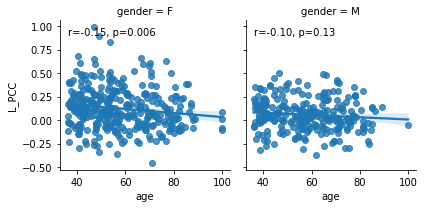

In [44]:
get_r_p(master_data_avg_seed, "L_PCC", "avg", "seed")

-0.2447436840939455
4.099719919189558e-06
-0.10893102822036832
0.0862789420325532


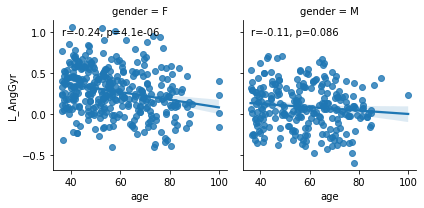

In [45]:
get_r_p(master_data_avg_seed, "L_AngGyr", "avg", "seed")

-0.2317155809211214
1.3369897462123796e-05
-0.11256349218902667
0.07624142254639271


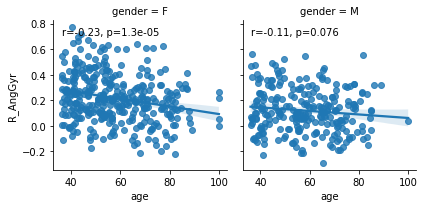

In [46]:
get_r_p(master_data_avg_seed, "R_AngGyr", "avg", "seed")

0.08026863824872113
0.1362018386453433
-0.040639599434553614
0.5232659914012947


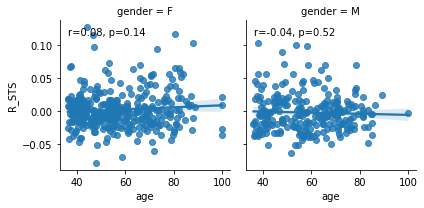

In [47]:
get_r_p(master_data_avg_seed, "R_STS", "avg", "seed")

### Generate boxplots with p-value annotations/mean trend lines

In [48]:
# L_PCC female vs male boxplot
conn_vs_age_boxplot(master_data_avg_seed, "L_PCC", "seed")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

(40, 50]_F v.s. (40, 50]_M: t-test independent samples with Bonferroni correction, P_val=6.787e-01 stat=1.670e+00
(30, 40]_F v.s. (30, 40]_M: t-test independent samples with Bonferroni correction, P_val=2.831e-01 stat=2.092e+00
(50, 60]_F v.s. (50, 60]_M: t-test independent samples with Bonferroni correction, P_val=6.053e-02 stat=2.665e+00
(60, 70]_F v.s. (60, 70]_M: t-test independent samples with Bonferroni correction, P_val=6.419e-01 stat=1.702e+00
(70, 80]_F v.s. (70, 80]_M: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=4.333e-01
(80, 90]_F v.s. (80, 90]_M: t-test independent samples with Bonferroni correction, P_val=4.456e-01 stat=1.905e+00
(90, 100]_F v.s. (90, 100]_M: t-test independent samples with Bonferroni correction, P_val=nan stat=nan


<Figure size 432x288 with 0 Axes>

In [49]:
# L_AngGyr female vs male boxplot
conn_vs_age_boxplot(master_data_avg_seed, "L_AngGyr", "seed")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

(40, 50]_F v.s. (40, 50]_M: t-test independent samples with Bonferroni correction, P_val=2.846e-04 stat=4.231e+00
(30, 40]_F v.s. (30, 40]_M: t-test independent samples with Bonferroni correction, P_val=2.113e-03 stat=3.826e+00
(50, 60]_F v.s. (50, 60]_M: t-test independent samples with Bonferroni correction, P_val=2.166e-05 stat=4.873e+00
(60, 70]_F v.s. (60, 70]_M: t-test independent samples with Bonferroni correction, P_val=4.656e-02 stat=2.769e+00
(70, 80]_F v.s. (70, 80]_M: t-test independent samples with Bonferroni correction, P_val=3.377e-02 stat=2.892e+00
(80, 90]_F v.s. (80, 90]_M: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=8.513e-01
(90, 100]_F v.s. (90, 100]_M: t-test independent samples with Bonferroni correction, P_val=nan stat=nan


<Figure size 432x288 with 0 Axes>

In [50]:
# R_AngGyr female vs male boxplot
conn_vs_age_boxplot(master_data_avg_seed, "R_AngGyr", "seed")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

(40, 50]_F v.s. (40, 50]_M: t-test independent samples with Bonferroni correction, P_val=4.519e-03 stat=3.486e+00
(30, 40]_F v.s. (30, 40]_M: t-test independent samples with Bonferroni correction, P_val=9.896e-01 stat=1.489e+00
(50, 60]_F v.s. (50, 60]_M: t-test independent samples with Bonferroni correction, P_val=6.109e-05 stat=4.628e+00
(60, 70]_F v.s. (60, 70]_M: t-test independent samples with Bonferroni correction, P_val=4.843e-01 stat=1.836e+00
(70, 80]_F v.s. (70, 80]_M: t-test independent samples with Bonferroni correction, P_val=8.045e-02 stat=2.581e+00
(80, 90]_F v.s. (80, 90]_M: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=2.063e-01
(90, 100]_F v.s. (90, 100]_M: t-test independent samples with Bonferroni correction, P_val=nan stat=nan


<Figure size 432x288 with 0 Axes>

In [51]:
# R_STS female vs male boxplot
conn_vs_age_boxplot(master_data_avg_seed, "R_STS", "seed")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

(40, 50]_F v.s. (40, 50]_M: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=2.625e-01
(30, 40]_F v.s. (30, 40]_M: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.744e-02
(50, 60]_F v.s. (50, 60]_M: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=9.440e-01
(60, 70]_F v.s. (60, 70]_M: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.727e-01
(70, 80]_F v.s. (70, 80]_M: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.091e+00
(80, 90]_F v.s. (80, 90]_M: t-test independent samples with Bonferroni correction, P_val=9.435e-02 stat=2.580e+00
(90, 100]_F v.s. (90, 100]_M: t-test independent samples with Bonferroni correction, P_val=nan stat=nan


<Figure size 432x288 with 0 Axes>

### Perform t-test between women and men by decade and collect t scores and p values (performed without Bonferroni correction!)

In [52]:
# perform t-test to compared L_PCC values between women and men by decade
ttest_seed = ttest_seed.append(ttest_age(master_data_avg_seed, 'L_PCC', 'seed'))
ttest_seed = ttest_seed.append(ttest_age(master_data_avg_seed, 'L_AngGyr', 'seed'))
ttest_seed = ttest_seed.append(ttest_age(master_data_avg_seed, 'R_AngGyr', 'seed'))
ttest_seed = ttest_seed.append(ttest_age(master_data_avg_seed, 'R_STS', 'seed'))

### Write all t-test values (stored in ttest_icd dataframe) into a .txt file

In [53]:
# write age groups, t values, and p values to a .txt file
ttest_seed.to_csv('ttest_seed.txt')
# print(ttest_seed)

### Generate plot to visualize all t values

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


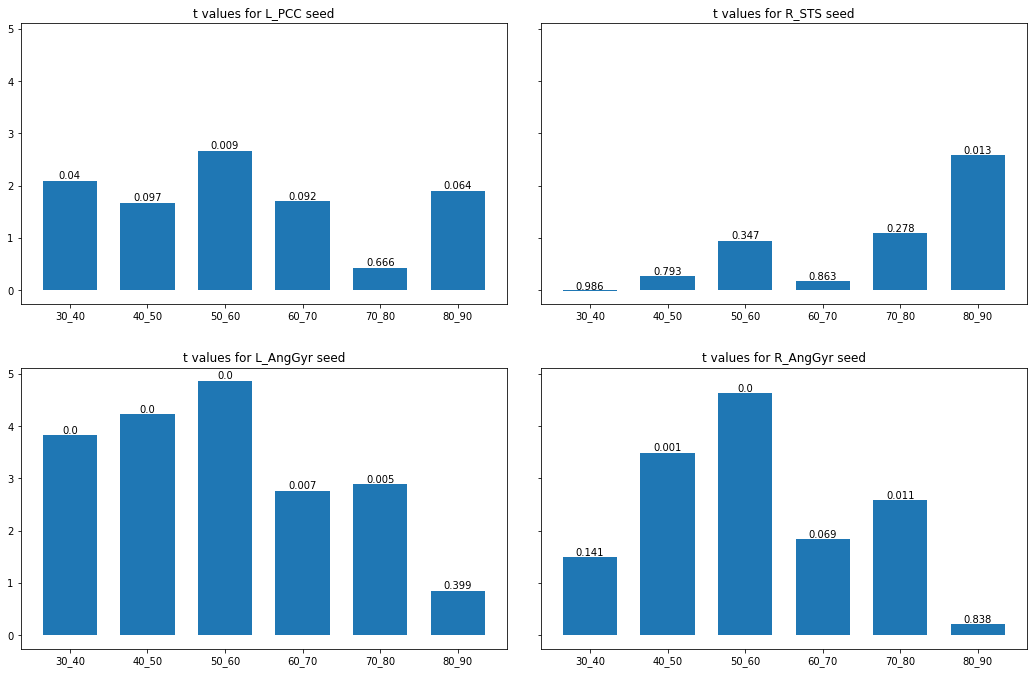

In [54]:
fig, axs = plt.subplots(2, 2, figsize = [15,10], sharey=True)
axs[0, 0].bar(ttest_seed[ttest_seed['ROI'] == 'L_PCC']['age_group'], ttest_seed[ttest_seed['ROI'] == 'L_PCC']['t value'], width = 0.7)
axs[0, 0].set_title("t values for L_PCC seed")
axs[0, 1].bar(ttest_seed[ttest_seed['ROI'] == 'R_STS']['age_group'], ttest_seed[ttest_seed['ROI'] == 'R_STS']['t value'], width = 0.7)
axs[0, 1].set_title("t values for R_STS seed")
axs[1, 0].bar(ttest_seed[ttest_seed['ROI'] == 'L_AngGyr']['age_group'], ttest_seed[ttest_seed['ROI'] == 'L_AngGyr']['t value'], width = 0.7)
axs[1, 0].set_title("t values for L_AngGyr seed")
axs[1, 1].bar(ttest_seed[ttest_seed['ROI'] == 'R_AngGyr']['age_group'], ttest_seed[ttest_seed['ROI'] == 'R_AngGyr']['t value'], width = 0.7)
axs[1, 1].set_title("t values for R_AngGyr seed")

rects = axs[0, 0].patches
labels = round(ttest_seed[ttest_seed['ROI'] == 'L_PCC']['p value'], 3)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[0, 0].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
    
rects = axs[0, 1].patches
labels = round(ttest_seed[ttest_seed['ROI'] == 'R_STS']['p value'], 3)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[0, 1].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
    
rects = axs[1, 0].patches
labels = round(ttest_seed[ttest_seed['ROI'] == 'L_AngGyr']['p value'], 3)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[1, 0].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
    
rects = axs[1, 1].patches
labels = round(ttest_seed[ttest_seed['ROI'] == 'R_AngGyr']['p value'], 3)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[1, 1].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
    
fig.tight_layout(pad = 3)
# plt.savefig('Seed t values')

### ...........................................................................................................................................................................................